# This is just importing packages and setting up Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet

In [ ]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 15 01:50:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

In [ ]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *
from sklearn.preprocessing import LabelEncoder


CPU times: user 10.9 s, sys: 841 ms, total: 11.7 s
Wall time: 12 s


# Defining some parameters.

In [ ]:
z_size = 16
hidden_layer_size = 256
k = 50
gpus = 1


# Load the data

Didn't need to pre-process since Zeisel is well processed, but the `process_data` function does exist!

In [ ]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/zeisel/'

In [ ]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [ ]:
X = adata.X.copy()

labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
Y = encoder.transform(labels)

In [ ]:
input_size = X.shape[1]
num_classes = len(encoder.classes_)

# Train MarkerMap in 3 Settings 

### Just a demo. Don't take the metrics seriously because I didn't use a test set.

## Purely unsupervised

In [ ]:
marker_map = MarkerMap(input_size = input_size, 
                       hidden_layer_size = hidden_layer_size, 
                       z_size = z_size, 
                       k = k,          
                       # PURELY UNSUPERVISED
                       num_classes = None,
                       loss_tradeoff = 1.0)


### Train using all the data. No early stopping with validation set

In [ ]:
markers, classifier, extras = marker_map.map(X = X, Y = Y, train_ratio = 1.0, gpus = gpus, min_epochs = 10, max_epochs = 25)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
markers

tensor([ 467,  118,  624, 2913,  620, 1121,  449,  451, 2105, 2101,  464,  922,
          77, 1463,   67,  480,   64,  580, 1080,   44, 1066,  352,  282,  293,
         757,  736,  241,  811,  323, 1243,  329,  347, 3999,  846,  358,  199,
         193, 1187,  169,  164,  159,  420,   33,    5,   22,   13, 1053,  506,
          23,    2])

In [ ]:
np.sum(classifier.predict(X[:, markers]) == Y) / len(Y)

1.0

### Not sure what should go in extras

In [ ]:
print(extras)

{'train_indices': array([2088, 2572,  588, ...,  400, 1140, 1842]), 'val_indices': None}


###

## Purely supervised

In [ ]:
marker_map = MarkerMap(input_size = input_size, 
                       hidden_layer_size = hidden_layer_size, 
                       z_size = z_size, 
                       k = k,          
                       # PURELY Supervised
                       num_classes = num_classes,
                       loss_tradeoff = 0)


### This time, 80% of the training data is used as validation data for early stopping of the model

In [ ]:
markers, classifier, extras = marker_map.map(X = X, Y = Y, train_ratio = 0.8, gpus = gpus, min_epochs = 10, max_epochs = 25)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


### Use the model itself to predict classes. 

In [ ]:
np.sum(marker_map.predict_class(X) == Y) / len(Y)

0.9257903494176373

### Can also use the classifier

In [ ]:
classifier.predict(X[:, markers])

array([2, 2, 2, ..., 1, 1, 1])

## Mix of supervised and unsupervised

In [ ]:
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

In [ ]:
marker_map = MarkerMap(input_size = input_size, 
                       hidden_layer_size = hidden_layer_size, 
                       z_size = z_size, 
                       k = k,          
                       # PURELY Supervised
                       num_classes = num_classes,
                       loss_tradeoff = 0.5)


In [ ]:
markers, classifier, extras = marker_map.map(X = X, Y = Y, train_ratio = 0.8, gpus = gpus, min_epochs = 10, max_epochs = 25)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------


# Do a plot from the Mix Supervised/Unsupervised setting

In [ ]:
if markers is not None:
    X_viz = X[:, markers]
embedding = umap.UMAP(n_neighbors=10, min_dist= 0.05).fit_transform(X_viz)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


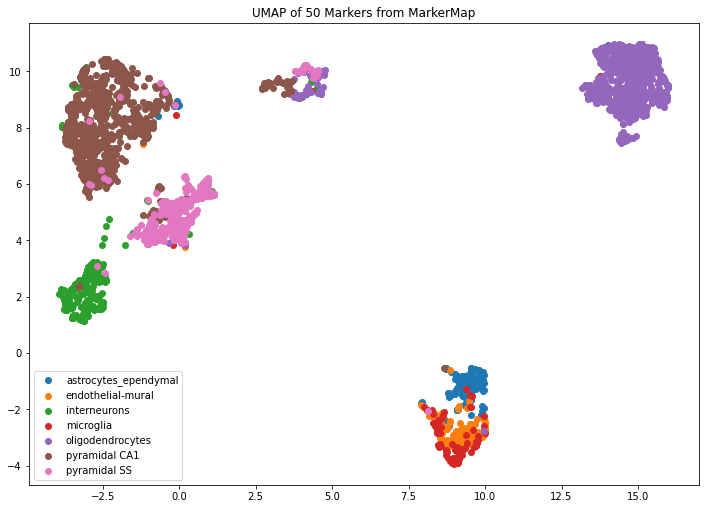

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8.5))

embedding_X, embedding_Y = embedding.T
# plt.setp(ax, xticks=[], yticks=[])
for class_i in range(num_classes):
    label = encoder.classes_[class_i]
    indices = Y == class_i
    plt.scatter(embedding_X[indices], embedding_Y[indices], label = label)
    
#cbar = plt.colorbar(ticks=np.arange(num_classes))#, boundaries = np.arange(num_classes) - 0.5)
#cbar.ax.set_yticklabels(encoder.classes_)


plt.legend()
plt.title('UMAP of 50 Markers from MarkerMap')
plt.show()